[![Labellerr](https://cdn.labellerr.com/%200%20Labellerr%20template/labellerr_banner.jpg)](https://www.google.com)

# SegFormer

---

[![labellerr](https://img.shields.io/badge/Labellerr-BLOG-black.svg)](https://www.labellerr.com/blog/<BLOG_NAME>)
[![Youtube](https://img.shields.io/badge/Labellerr-YouTube-b31b1b.svg)](https://www.youtube.com/@Labellerr)
[![Github](https://img.shields.io/badge/Labellerr-GitHub-green.svg)](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)
[![Scientific Paper](https://img.shields.io/badge/Official-Paper-blue.svg)](<PAPER LINK>)

# About SegFomer

SegFormer represents a pivotal shift in how semantic segmentation is approached, blending the global context modeling of Transformers with the efficiency of lightweight MLPs. Unlike earlier models that relied on heavy convolutional architectures or complex decoders, SegFormer introduces a clean, simple design that excels across diverse environments.

## Set-up environment

First, let's install 🤗 Transformers.

In [3]:
!pip install transformers torch pillow matplotlib numpy

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Load model and image processor

Here we load the model as well as the image processor from the [HuggingFace Hub](https://huggingface.co/). Note that NVIDIA has released several checkpoints, all of which can be found [here](https://huggingface.co/models?other=segformer). Be sure to play around with them!

The image processor can be used to prepare images for the model, and postprocess the results.

We move the model to GPU if it's available.

In [3]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
# we are going to do whole inference, so no resizing of the image
processor = SegformerImageProcessor(do_resize=False)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

## Prepare image

Here, we load an image from the ADE20k dataset (actually called the [MIT Scene Parsing Benchmark](http://sceneparsing.csail.mit.edu/)), an important benchmark for semantic segmentation. We also load its corresponding ground truth segmentation map.

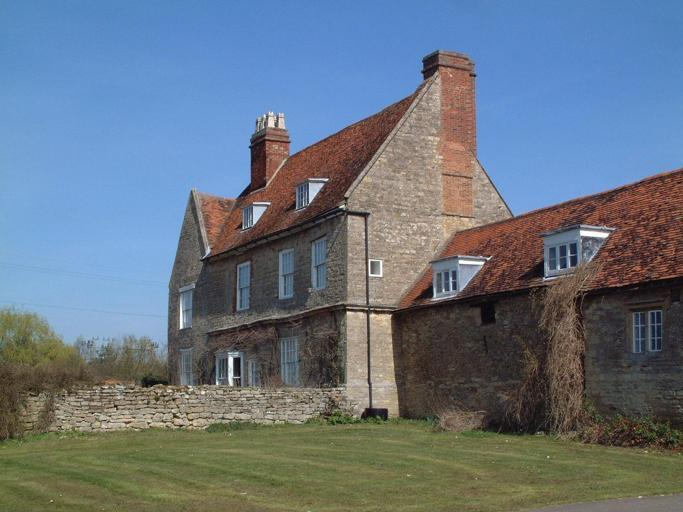

In [4]:
from huggingface_hub import hf_hub_download
from PIL import Image

# load image + ground truth map
repo_id = "hf-internal-testing/fixtures_ade20k"
image_path = hf_hub_download(repo_id=repo_id, filename="ADE_val_00000001.jpg", repo_type="dataset")
image = Image.open(image_path)
segmentation_map_path = hf_hub_download(repo_id=repo_id, filename="ADE_val_00000001.png", repo_type="dataset")
segmentation_map = Image.open(segmentation_map_path)
image

We can prepare the image for the model using the image processor. It will resize the image + normalize the channels.

In [5]:
pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

In [6]:
print(pixel_values.shape)

torch.Size([1, 3, 512, 683])


## Forward pass

Next, let's forward the pixel values through the model in order to obtain the logits. Note that we use `torch.no_grad()` here as we don't need to compute gradients at inference time, saving us memory.

In [7]:


with torch.no_grad():
  outputs = model(pixel_values)
  logits = outputs.logits

The model outputs logits of shape `(batch_size, num_labels, height/4, width/4)`:

In [8]:
type(outputs[0])

torch.Tensor

In [9]:
print(logits.shape)

torch.Size([1, 150, 128, 171])


## Visualize

Finally, let's visualize the segmentation map as predicted by the model. Semantic segmentation datasets typically define what is called a "color palette", that defines the RGB color values to use for each of the classes.

The ADE20k dataset consists of 150 classes, so the list below has 150 elements.

In [10]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

We can leverage the [post_process_semantic_segmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerImageProcessor.post_process_semantic_segmentation) method of the image processor, which will rescale the logits to match the original size of the image using bilinear interpolation. Next, it performs an argmax on the class dimension, to get a predicted class per pixel.

In [11]:
predicted_segmentation_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[ 2  2  2 ...  2  2  2]
 [ 2  2  2 ...  2  2  2]
 [ 2  2  2 ...  2  2  2]
 ...
 [ 9  9  9 ... 52 52 52]
 [ 9  9  9 ... 52 52 52]
 [ 9  9  9 ... 52 52 52]]


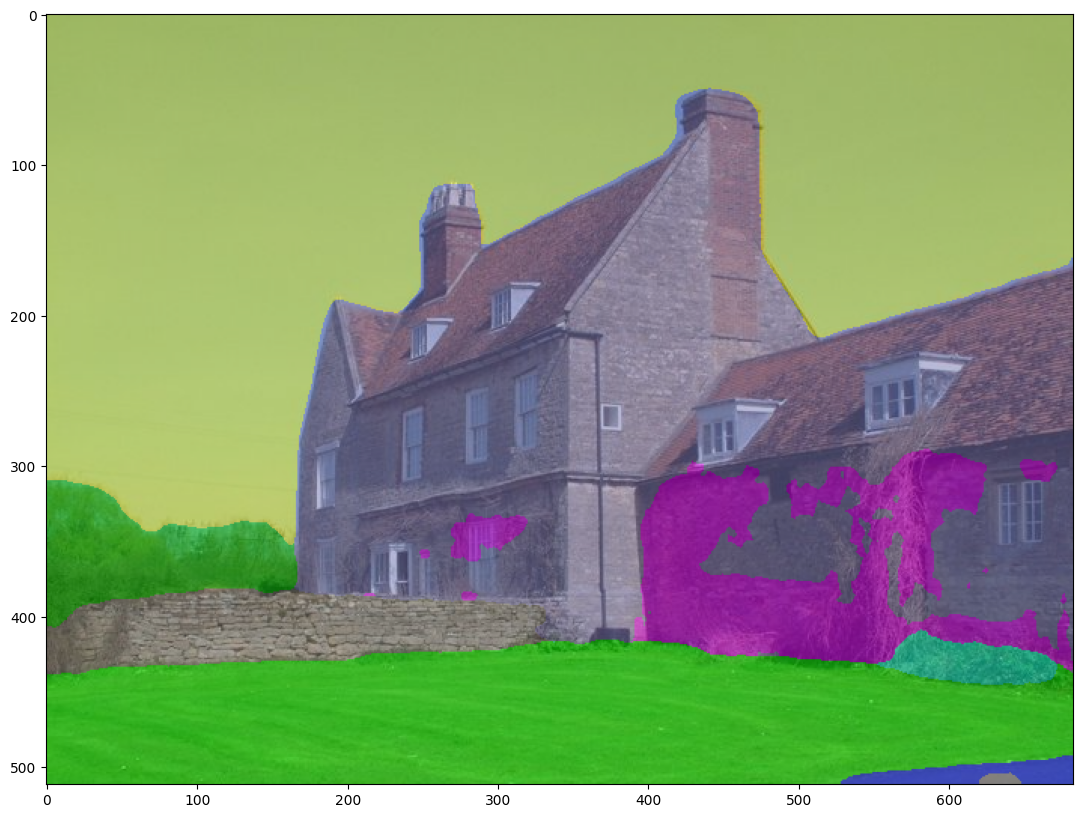

In [12]:


color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth:

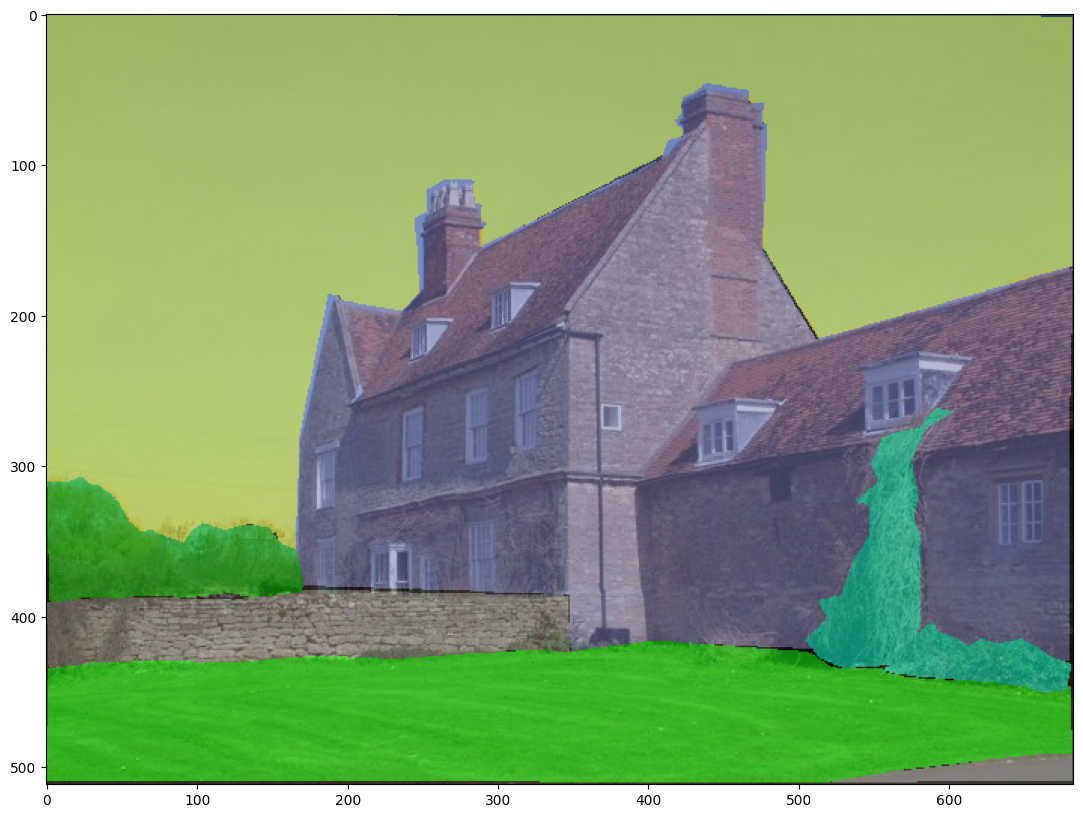

In [13]:
ground_truth_seg = np.array(segmentation_map) # 2D ground truth segmentation map
ground_truth_color_seg = np.zeros((ground_truth_seg.shape[0], ground_truth_seg.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    ground_truth_color_seg[ground_truth_seg - 1 == label, :] = color
# Convert to BGR
ground_truth_color_seg = ground_truth_color_seg[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [14]:
import requests
from io import BytesIO
from PIL import Image
import numpy as np
import torch
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# Initialize model and processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
processor = SegformerImageProcessor(do_resize=False)
model = SegformerForSemanticSegmentation.from_pretrained(model_name)
model.to(device)


def segment_image(input_image, alpha: float = 0.5) -> Image.Image:
    """
    Performs semantic segmentation on an image and returns an overlay mask.

    Args:
        input_image (str or PIL.Image): Path to an image file, URL, or a PIL Image instance.
        alpha (float): Blending factor for overlay. 0 = only original, 1 = only mask.

    Returns:
        PIL.Image: The original image blended with the segmentation mask.
    """
    # Load image
    if isinstance(input_image, str):
        if input_image.startswith(('http://', 'https://')):
            resp = requests.get(input_image)
            img = Image.open(BytesIO(resp.content)).convert("RGB")
        else:
            img = Image.open(input_image).convert("RGB")
    elif isinstance(input_image, Image.Image):
        img = input_image.convert("RGB")
    else:
        raise ValueError("Unsupported input type. Provide a file path, URL, or PIL.Image.")

    # Preprocess and forward pass
    pixel_values = processor(img, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        outputs = model(pixel_values)

    # Post-process to get mask
    seg_map = processor.post_process_semantic_segmentation(
        outputs, target_sizes=[img.size[::-1]]
    )[0].cpu().numpy()

    # Create color mask
    palette = np.array(ade_palette(), dtype=np.uint8)
    color_mask = np.zeros((seg_map.shape[0], seg_map.shape[1], 3), dtype=np.uint8)
    for label, color in enumerate(palette):
        color_mask[seg_map == label] = color

    # Blend original and mask
    orig_arr = np.array(img)
    overlay = (orig_arr * (1 - alpha) + color_mask * alpha).astype(np.uint8)
    return Image.fromarray(overlay)


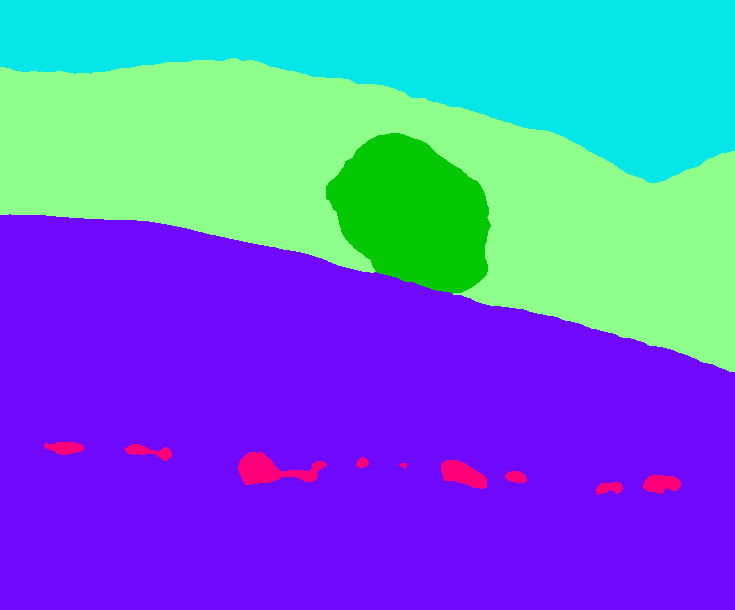

In [15]:
# Example usage:
result = segment_image("https://i.pinimg.com/736x/17/e7/fc/17e7fc299466b2afd989e709fe7c9815.jpg", alpha=1)
result

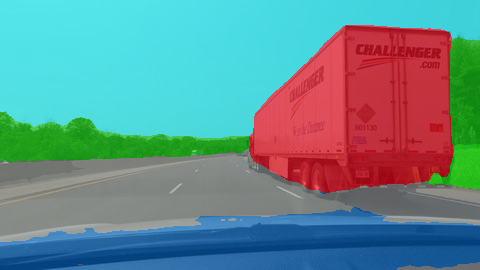

In [16]:
# Example usage:
url = "https://www.shutterstock.com/shutterstock/videos/1106252821/thumb/1.jpg?ip=x480"
result = segment_image(url, alpha=0.6)
result

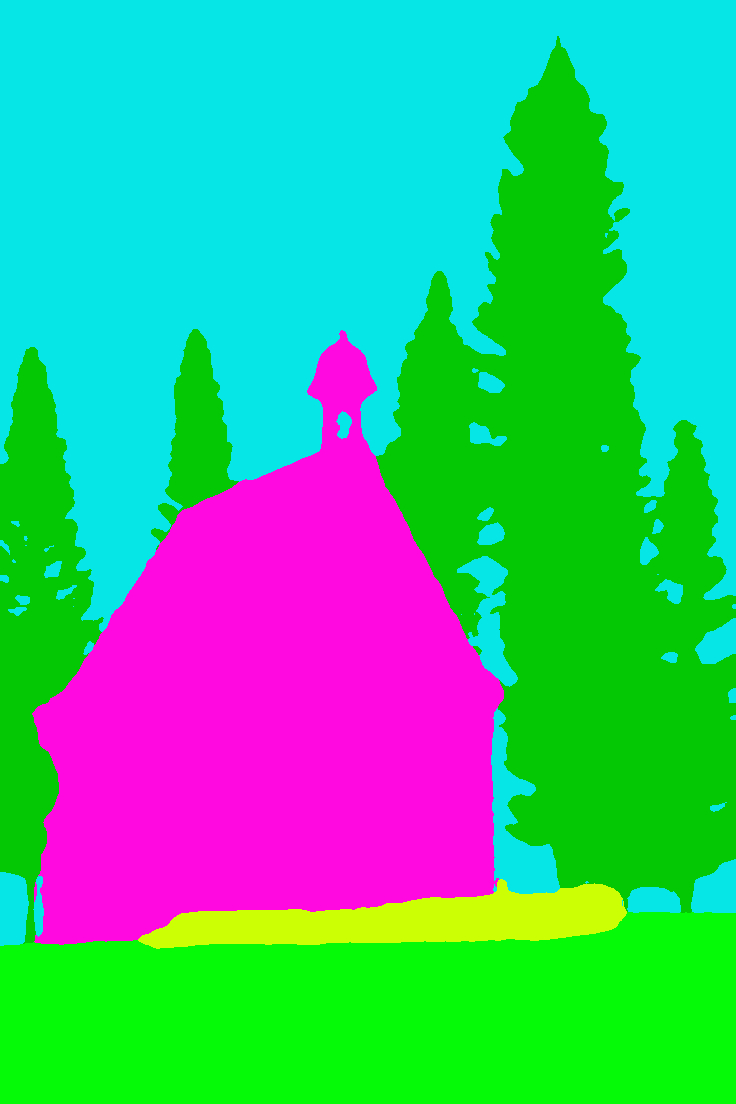

In [18]:
# Example usage:
url = "https://i.pinimg.com/736x/86/f6/07/86f60748d5d9ae4cb9092018d1321648.jpg"
result = segment_image(url, alpha=1)
result

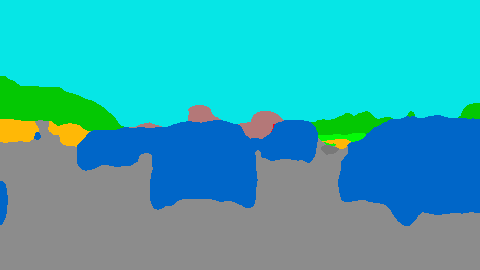

In [ ]:
# Example usage:
url = "https://images.pond5.com/pov-car-and-truck-traffic-footage-190002081_iconl.jpeg"
result = segment_image(url, alpha=1)
result

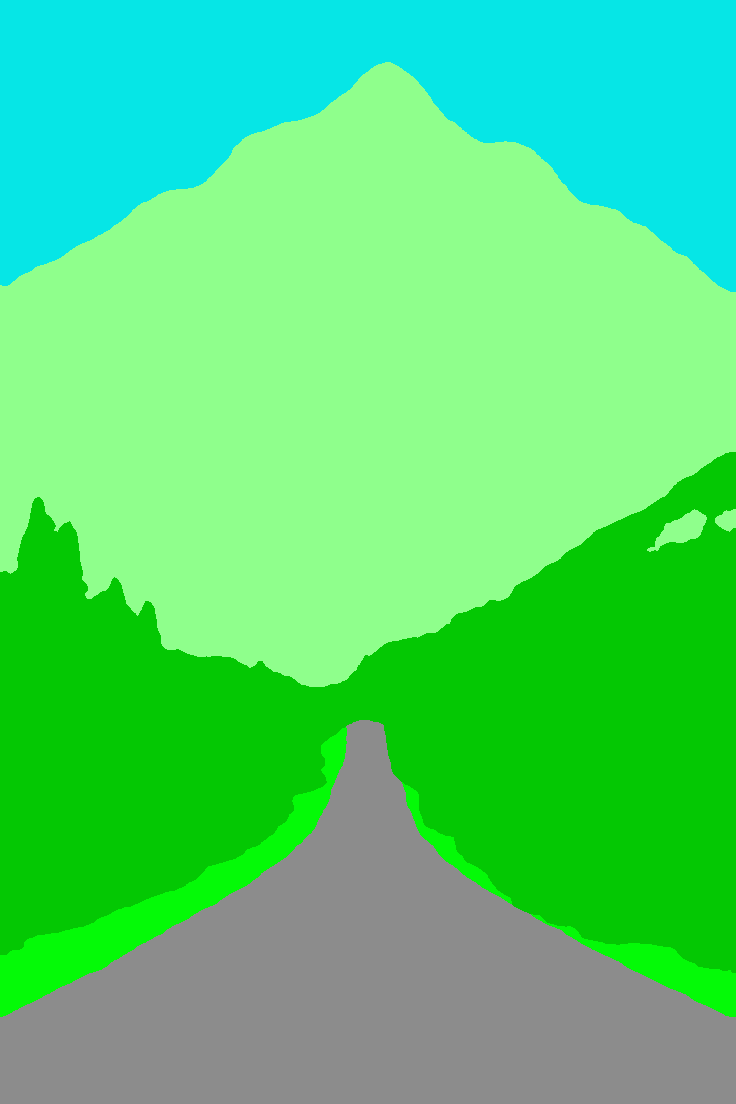

In [24]:
# Example usage:
url = "https://i.pinimg.com/736x/17/66/c4/1766c4f667af39f91172ef8eb21ab18a.jpg"
result = segment_image(url, alpha=1)
result

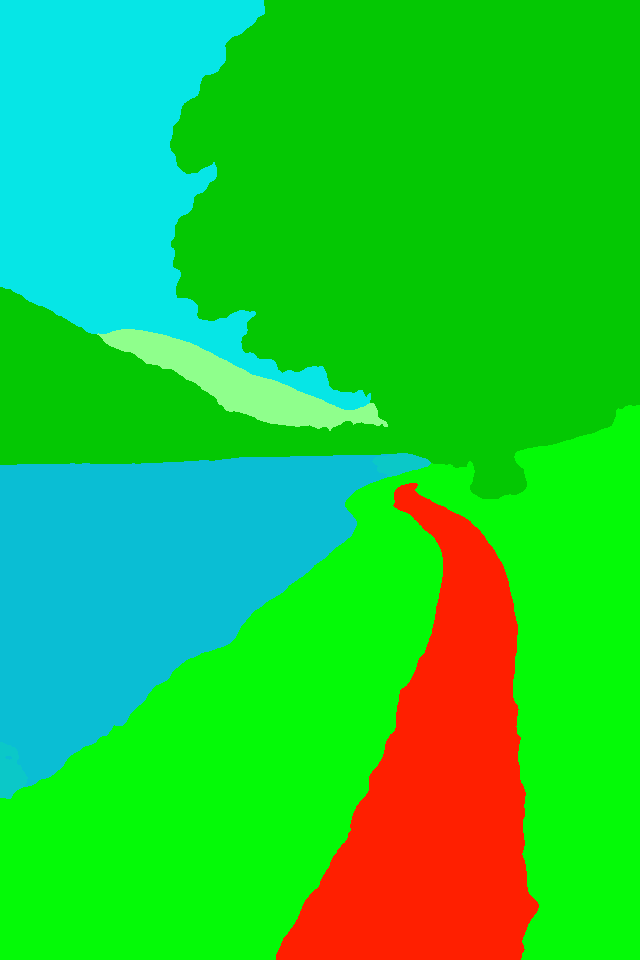

In [27]:
# Example usage:
url = "https://i.pinimg.com/736x/f7/5a/f2/f75af26820b50c24600f50f3998eb02f.jpg"
result = segment_image(url, alpha=1)
result